# 25. Denoising AutoEncoder

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.init
from torch.autograd import Variable

import torchvision
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 25.1 Preparing SVHN Data

In [3]:
svhn_train = dsets.SVHN(root='data/',
                          split='train',
                          transform=transforms.ToTensor(),
                          download=True)

svhn_test = dsets.SVHN(root='data/',
                         split='test',
                         transform=transforms.ToTensor(),
                         download=True)

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


In [4]:
batch_size = 100

train_loader  = torch.utils.data.DataLoader(dataset=svhn_train,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=svhn_test,
                                         batch_size=1,
                                         shuffle=False)

In [5]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

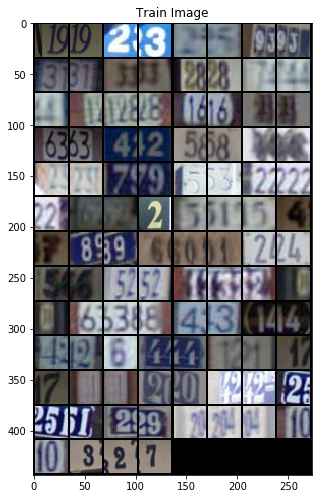

In [6]:
images, labels = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images, normalize=True), "Train Image")

In [7]:
images.shape

torch.Size([100, 3, 32, 32])

## 25.2 Define Model

In [8]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3,16,5),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16,32,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(32),
            nn.Conv2d(32,64,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2) #64*4*4
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(64*4*4, 100),
            nn.ReLU(),
            nn.Linear(100, 100)
        )
        
    def forward(self, x):
        out = self.encoder(x)
        z = self.fc_layer(out.view(-1, 64*4*4))
        
        return z

In [9]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.fc_layer = nn.Sequential(
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 64*4*4)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64,32,4,stride=2,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32,16,4,stride=2,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16,3,4,stride=2,padding=1),
            nn.ReLU()
        )
        
    def forward(self, z):
        out = self.fc_layer(z)
        out = out.view(-1, 64, 4, 4)
        out = self.decoder(out)
        
        return out

In [10]:
E = Encoder().cuda()
D = Decoder().cuda()

In [11]:
E(torch.randn(100, 3, 32, 32).cuda()).shape

torch.Size([100, 100])

In [12]:
D(torch.randn(100, 100).cuda()).shape

torch.Size([100, 3, 32, 32])

## 25.3 Model Training

In [13]:
loss = nn.MSELoss()
optimizer = optim.Adam(list(E.parameters()) + list(D.parameters()), lr=0.001)

In [14]:
num_epochs = 5

In [15]:
for epoch in range(num_epochs):
    
    total_batch = len(svhn_train) // batch_size
    
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        
        X = batch_images.cuda()
        
        noise = torch.randn(X.size())*0.1
        noise = noise.cuda()
        
        noise_X = X + noise
        
        pre = D(E(noise_X))
        cost = loss(pre, X)
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, cost.item()))
    
print("Learning Finished!")

Epoch [1/5], lter [100/732], Loss: 0.0309
Epoch [1/5], lter [200/732], Loss: 0.0115
Epoch [1/5], lter [300/732], Loss: 0.0098
Epoch [1/5], lter [400/732], Loss: 0.0109
Epoch [1/5], lter [500/732], Loss: 0.0089
Epoch [1/5], lter [600/732], Loss: 0.0077
Epoch [1/5], lter [700/732], Loss: 0.0070
Epoch [2/5], lter [100/732], Loss: 0.0057
Epoch [2/5], lter [200/732], Loss: 0.0057
Epoch [2/5], lter [300/732], Loss: 0.0056
Epoch [2/5], lter [400/732], Loss: 0.0068
Epoch [2/5], lter [500/732], Loss: 0.0053
Epoch [2/5], lter [600/732], Loss: 0.0055
Epoch [2/5], lter [700/732], Loss: 0.0054
Epoch [3/5], lter [100/732], Loss: 0.0047
Epoch [3/5], lter [200/732], Loss: 0.0051
Epoch [3/5], lter [300/732], Loss: 0.0049
Epoch [3/5], lter [400/732], Loss: 0.0061
Epoch [3/5], lter [500/732], Loss: 0.0049
Epoch [3/5], lter [600/732], Loss: 0.0050
Epoch [3/5], lter [700/732], Loss: 0.0050
Epoch [4/5], lter [100/732], Loss: 0.0043
Epoch [4/5], lter [200/732], Loss: 0.0049
Epoch [4/5], lter [300/732], Loss:

## 25.4 Test Model

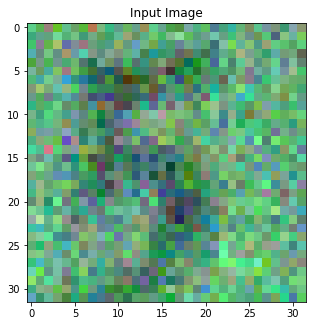

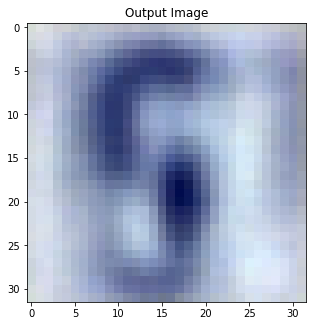

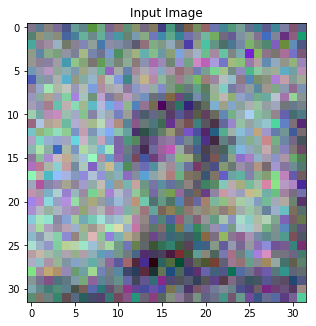

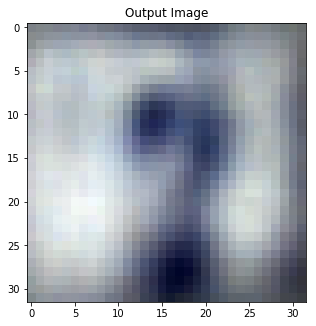

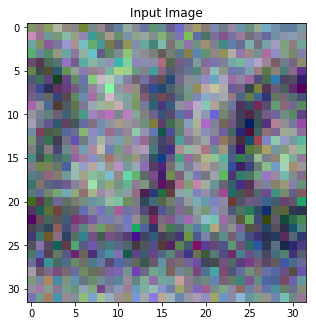

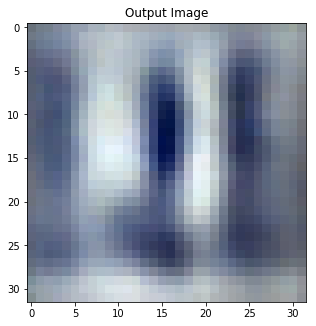

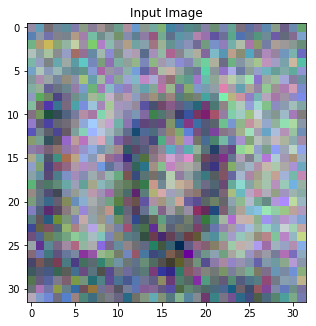

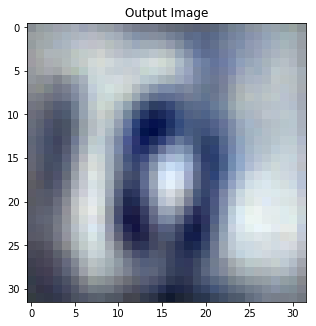

In [16]:
E.eval()
D.eval()

for n, (images, labels) in enumerate(test_loader):
    
    images = Variable(images).cuda()
    
    noise = torch.randn(images.size())*0.1
    noise = noise.cuda()
    
    noise_images = images + noise
    
    imshow(torchvision.utils.make_grid(noise_images.data.cpu(), normalize=True), "Input Image")
        
    outputs = D(E(noise_images))
    
    imshow(torchvision.utils.make_grid(outputs.data.cpu(), normalize=True), "Output Image")
    
    if n > 2 : break